In [2]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import os 
import numpy as np
import time
import matplotlib
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
import matplotlib.pyplot as plt
import matplotlib.patches as Polygon
import copy as cp
import cmocean
import glob 
import xarray

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_moc   import *
from colormap_c2c    import *

In [3]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'],inputarray['save_figpath'] = False, '/home/ollie/pscholz/figures/test_pgf/linear/'
inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2', '/work/ollie/pscholz/mesh_fesom2.0/core2_minz/'
try:
	mesh
except NameError:
	mesh = fesom_init_mesh(inputarray)
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
_______________________________________________________________


# Calculate Meridional Overturning Circulation (MOC) Profile

Use for the calculation of the Meridional Overturning Circulation (MOC) the equation for the calculation of the "Pseudostreamfunction". Condition for the calculation of the regional MOC (i.e AMOC, PMOC, IMOC) is that the domain over which the caluclation is carried out, is approximately sorounded by a coast (Bering Strait can be accouted as coast its just 30m deep). Since Atlantic, Pacific and Indian Ocean have no southern coastal boundary the AMOC and PMOC can just be calculated until -30°S and the meridional cumulativ integration has to be carried out from North to South instead South to North which leads to an additional minus sign in the calcualtion (see: sub_fesom_moc.py, line:137)
$${\int_E^W w(x',y,z) dx' = {{\partial\Psi} \over {\partial y}}}$$
$$ \textrm{GMOC:} ~~~  {\Psi(y,z) = \int_S^N {\int_E^W w(x',y',z) \cdot dx'} dy'} ~~$$
$$ \textrm{AMOC:} ~~~  {\Psi(y,z) = -\int_N^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$
$$ \textrm{PMOC:} ~~~  {\Psi(y,z) = -\int_{Bering Strait} ^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$

<IPython.core.display.Javascript object>


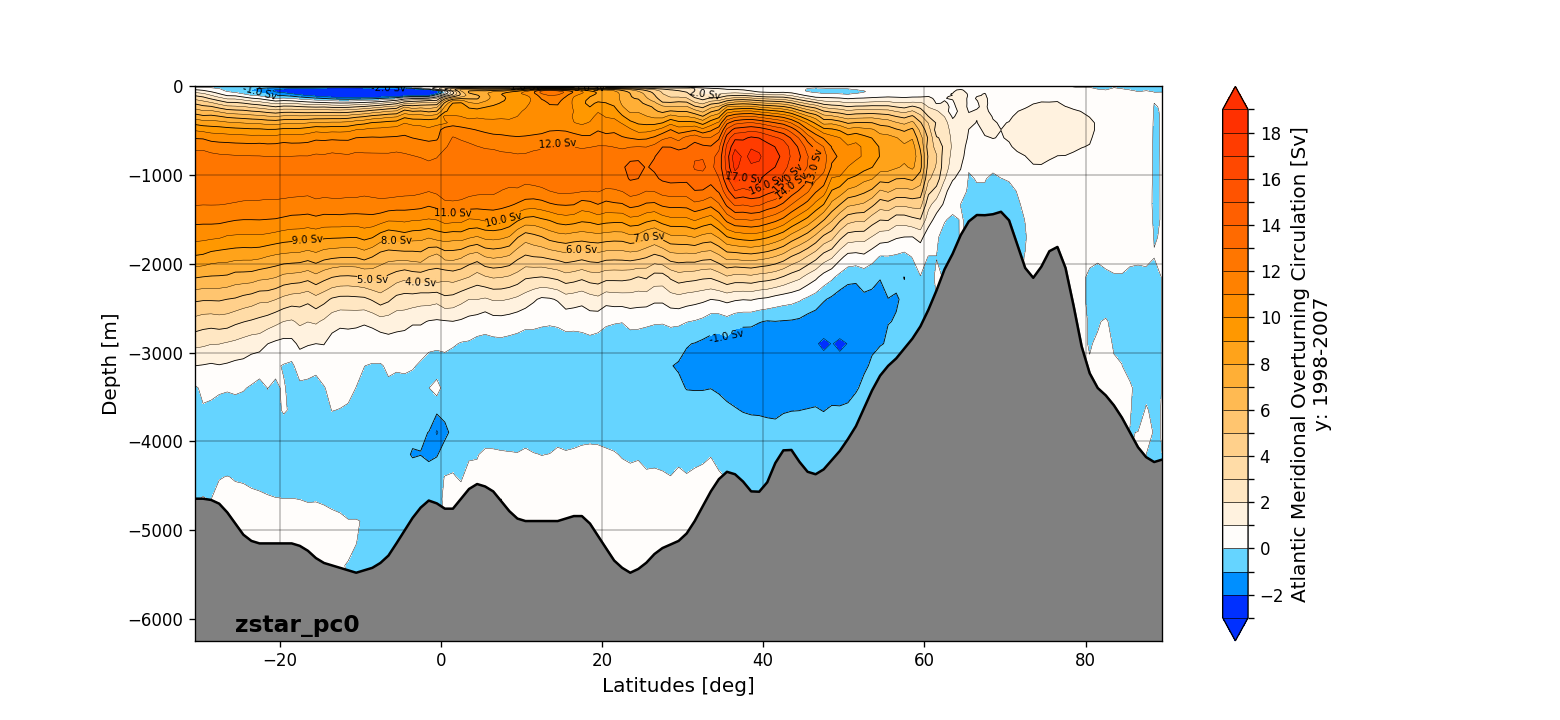

-2.11182305974 18.720257354 0.0


/home/ollie/pscholz/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


In [4]:
#%%prun -s cumulative -q -l 100 -D profile.bin
#____________________________________________________________________________________________________
# load vertical velocity data
data1 		 	= fesom_data(inputarray) 
data1.var 		= 'w'
data1.descript,data1.path = 'zstar' ,'../results/new_zstar/pc0/2/'
data1.year, data1.month= [1998,2007], [1,2,3,4,5,6,7,8,9,10,11,12]
data1.cmap,data1.cnumb = 'blue2red', 10
add_bolusw = True
#____________________________________________________________________________________________________
# load vertical velocity datas for big meshes using xarray
fesom_load_data3d_4bm(mesh,data1,do_output=False)

#____________________________________________________________________________________________________
# add GM bolus velocity
if add_bolusw:
    data_bw     = cp.deepcopy(data1)
    data_bw.var ='bolus_w'
    fesom_load_data_horiz(mesh,data_bw,do_output=False)
    data1.value = data1.value+data_bw.value
    del data_bw

#%%prun -s cumulative -q -l 100 -D profile.bin #write out profile file usable with snakeviz profile.bin
#____________________________________________________________________________________________________
# select XMOC
which_moc = 'amoc'

#____________________________________________________________________________________________________
# calc XMOC
moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=which_moc,out_elemidx=True)
#moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc,in_elemidx=elemidx)

# moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=amoc,out_elemidx=True)
# --> writes out elem index to use for AMOC or PMOC can be directly read into next calucation of amoc 
# --> moc2,lat,bottom      =calc_xmoc(mesh,data2,which_moc=amoc,in_elemidx=elemidx)
#____________________________________________________________________________________________________
# plot XMOC
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=[],cnumb=15)

#____________________________________________________________________________________________________
# save XMOC
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=600, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    
#____________________________________________________________________________________________________    
# which_moc = 'amoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'pmoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'imoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)

## --> Calculate anomaly of MOC

_____calc. GMOC from vertical velocities via meridional bins_____
 --> total time:0.753 s
_____calc. GMOC from vertical velocities via meridional bins_____
 --> total time:0.627 s
_____calc. GMOC from vertical velocities via meridional bins_____
 --> total time:0.630 s


<IPython.core.display.Javascript object>


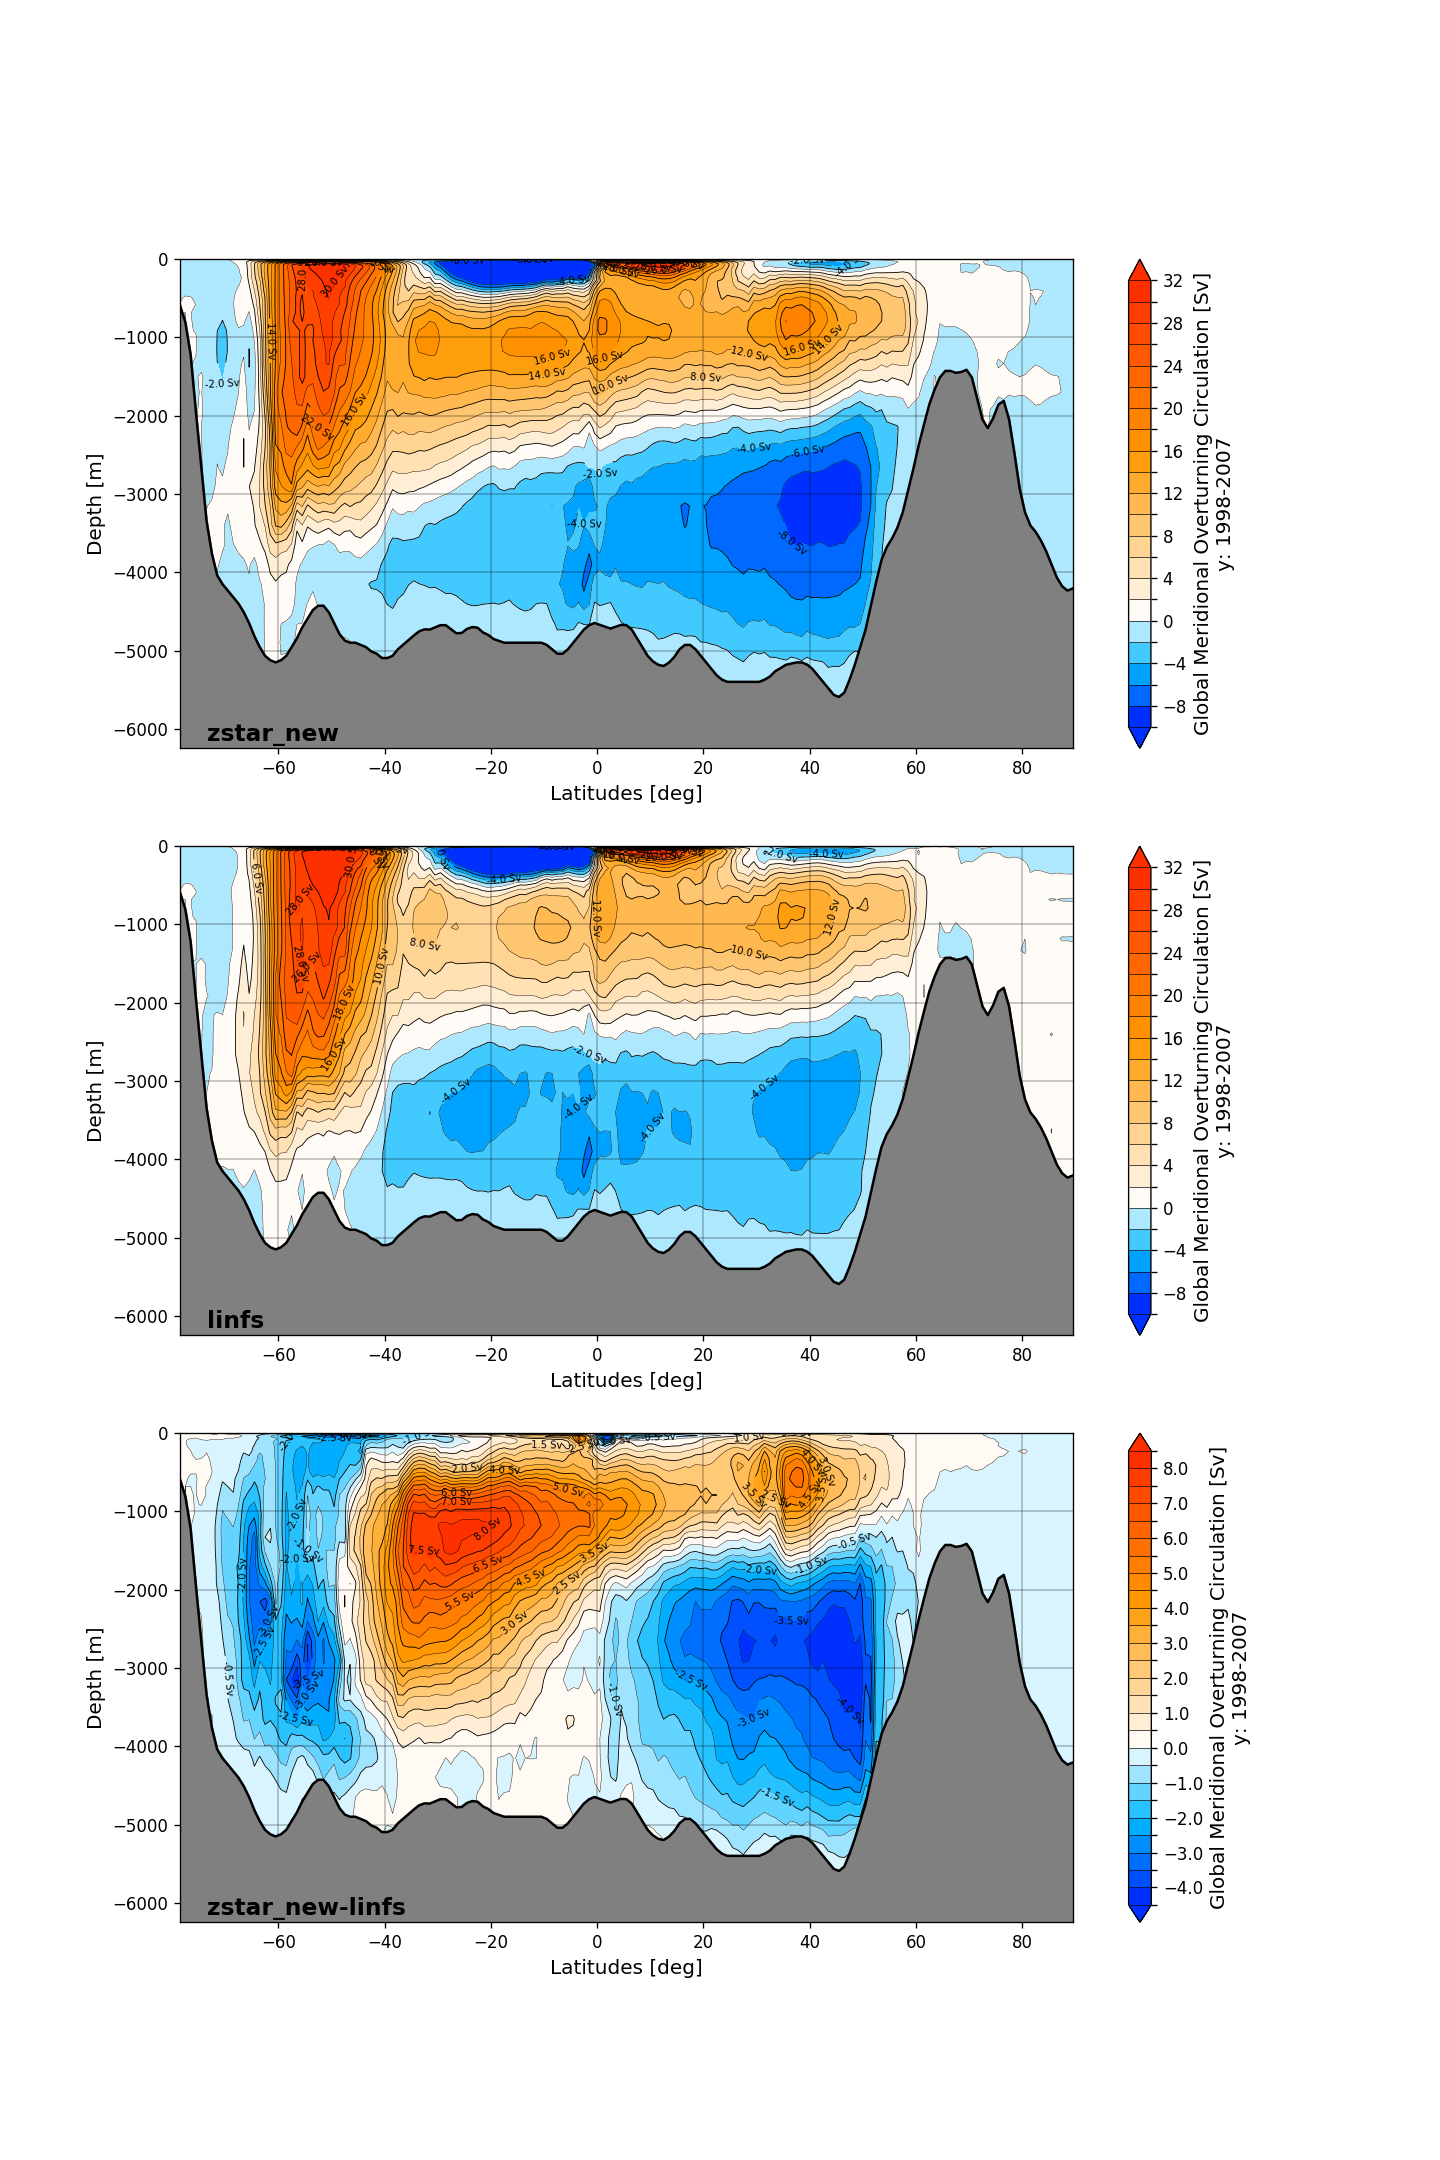

-9.10418342282 31.6553475506 0.0
-9.10418342282 31.6553475506 0.0
-4.49010706296 8.20282390168 0.0


/home/ollie/pscholz/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


In [17]:
which_moc = 'gmoc'
#____________________________________________________________________________________________________
# load vertical velocity data
data1 = fesom_data(inputarray) 
data1.descript,data1.path = 'zstar_new' ,'../results/new_zstar/pc0/2/'
data1.var, data1.year, data1.month = 'w', [1998,2007], [1,2,3,4,5,6,7,8,9,10,11,12]
fesom_load_data3d_4bm(mesh,data1,do_output=False)

data2 = cp.deepcopy(data1)
data2.descript,data2.path = 'linfs' ,'../results/linfs/kpp/2/'
fesom_load_data3d_4bm(mesh,data2,do_output=False)

anom  = fesom_data_anom(data2,data1)

#____________________________________________________________________________________________________
# calc XMOC anomaly
moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
moc2,lat,bottom  = calc_xmoc(mesh,data2,which_moc=which_moc)
# moca,lat,bottom  = calc_xmoc(mesh,anom,which_moc=which_moc)
moca = moc1-moc2

#____________________________________________________________________________________________________
# plot XMOC anomaly
cmin   = np.min([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].min(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].min()])
cmax   = np.max([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].max(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].max()])
crange = [cmin,cmax,0.0]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=[12,18])
fig,ax1=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,do_subplot=[fig,ax1],which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=crange)
fig,ax2=plot_xmoc(lat,mesh.zlev,moc2,bottom=bottom,do_subplot=[fig,ax2],which_moc=which_moc,str_descript=data2.descript,str_time=data2.str_time,crange=crange)
fig,ax3=plot_xmoc(lat,mesh.zlev,moca,bottom=bottom,do_subplot=[fig,ax3],which_moc=which_moc,str_descript=anom.descript ,str_time=anom.str_time)

## --> Calculate MOC Time-Series

 --> CALC YEAR:
|1948 >> use rtracing parallel  >> time: 1.030 s
|1949|1950|1951|1952|1953|1954|1955|1956|1957|1958|1959|1960|1961|1962|
|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|
|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|
|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|
|2008|2009

<IPython.core.display.Javascript object>


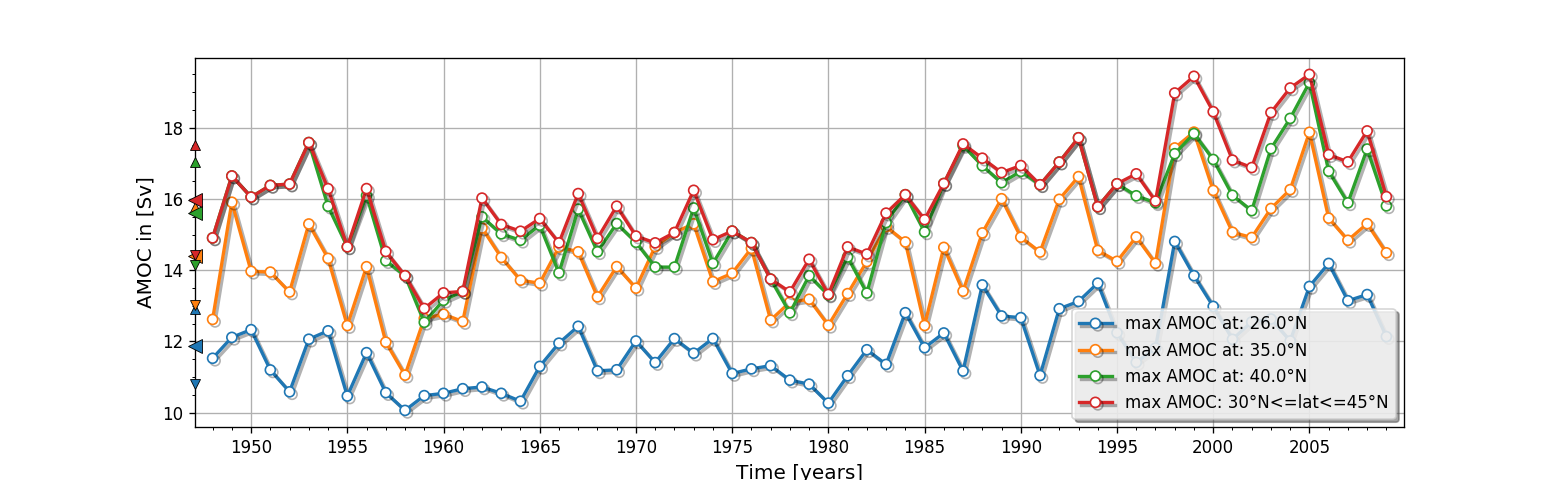

In [9]:
which_moc='amoc'
which_lat=[26.0, 35.0, 40.0,'max']
#____________________________________________________________________________________________________
# load vertical velocity data
data1 	   = fesom_data(inputarray) 
data1.var = 'w'
data1.descript,data1.path, = 'zstar','../results/new_zstar/pc0/2/'
data1.year, data1.month = [1948,2009], [1,2,3,4,5,6,7,8,9,10,11,12]

#____________________________________________________________________________________________________
# be sure mesh has the right focus 
if which_moc=='amoc2' or which_moc=='amoc':
    # for calculation of amoc mesh focus must be on 0 degree longitude
    if mesh.focus!=0:
       mesh.focus=0
       mesh.fesom_grid_rot_r2g(str_mode='focus')
elif which_moc=='pmoc':
     if mesh.focus!=180:
        mesh.focus=180
        mesh.fesom_grid_rot_r2g(str_mode='focus')
#____________________________________________________________________________________________________
# calc MOC time-series
count=0
print(' --> CALC YEAR:')
datayr = cp.deepcopy(data1)
moc_t = np.zeros((data1.year[1]-data1.year[0]+1,len(which_lat)))
time  = np.zeros((data1.year[1]-data1.year[0]+1,))
for year in range(data1.year[0],data1.year[1]+1):
    #_______________________________________________________________________________________________
    print('|'+str(year),end='')
    if np.mod(count+1,15)==0: print('|')
        
    #_______________________________________________________________________________________________
    # load vertical velocity data --> calculates yearly means
    datayr.year		= [year,year]
    # fesom_load_data_horiz(mesh,datayr,do_output=False)
    fesom_load_data3d_4bm(mesh,datayr,do_output=False) 
    
    #_______________________________________________________________________________________________
    # calculate AMOC vor every year
    if count==0:
        moc_prof,lat,bottom,elemidx  = calc_xmoc(mesh,datayr,which_moc=which_moc,out_elemidx=True,do_output=False)
    else:
        moc_prof,lat,bottom          = calc_xmoc(mesh,datayr,which_moc=which_moc,in_elemidx=elemidx,do_output=False)
    #_______________________________________________________________________________________________
    # look for maximum value below 500m at certain latitude or between latitudinal range 'max' 
    # (looks between 30°N and 45°N)
    moc_d=moc_prof[np.where(mesh.zlev<=-500)[0],:]
    count_lat=0
    for lati in which_lat:
        if lati=='max':
            moc_l= moc_d[:,np.where((lat>=30) & (lat<=45))[0]]
        else:
            moc_l= moc_d[:,np.where(lat>=lati)[0][0]]
        moc_t[count,count_lat]=moc_l.max()
        count_lat=count_lat+1
    time[count]=year    
    count=count+1
    
#____________________________________________________________________________________________________
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc)    